# Main Goals of the project
- predict 'taxvaluedollarcount'
    - on single unit properties
    - between May and June of 2017
- what states and counties are properties located
- plot distribution of tax rates for each county

For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product).

In [1]:
import pandas as pd
from prepare import scale_wrangle_mvp_zillow

### Data Prep
- grabbed all data that had the title single family residential
- dropped all null values for sqrft(24)
- dropped all bedrooms == 0 (18)
- dropped all bathrooms == 0 (4)


In [2]:
train, validate, test = scale_wrangle_mvp_zillow()

In [3]:
train.head()

,sqrft,bedroom,bathroom,taxvalue,sqrft_scaled,bedroom_scaled,bathroom_scaled
13700,1122.0,3.0,1.0,69246.0,0.054257,0.181818,0.000000
13662,3794.0,3.0,3.5,1600000.0,0.230627,0.181818,0.277778
4257,1541.0,3.0,1.0,130067.0,0.081914,0.181818,0.000000
1486,1207.0,2.0,1.0,274868.0,0.059868,0.090909,0.000000
6746,2247.0,3.0,3.0,431695.0,0.128515,0.181818,0.222222


### Data Exploration

#### Is tax value independent from the amount of bedrooms?

##### Hypothesis 1:

$H_0$: Tax value and the amount of bedrooms are **independent**

$H_a$: Tax value and the amount of bedrooms are **dependent**


In [4]:
from scipy import stats

In [5]:
x = train.bedroom
y = train.taxvalue

In [6]:
alpha = .05

In [7]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.2669555883591621, 1.3769600444111775e-146)

In [8]:
print('Correlation between tax value and bedrooms')
print(f'  r = {corr:.3f}')

Correlation between tax value and bedrooms
  r = 0.267


In [9]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.3769600444111775e-146

In [10]:
x2 = train.bathroom
y = train.taxvalue

In [11]:
corr2, p2 = stats.pearsonr(x2, y)
corr2, p2

(0.5237923359332888, 0.0)

In [12]:
print('Correlation between tax value and bedrooms')
print(f'  r = {corr2:.3f}')

Correlation between tax value and bedrooms
  r = 0.524


In [13]:
if p2 < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p2

We reject the null


0.0

In [14]:
x3 = train.sqrft
y = train.taxvalue

In [15]:
corr3, p3 = stats.pearsonr(x3, y)
corr3, p3

(0.6117554733189965, 0.0)

In [16]:
if p3 < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p3

We reject the null


0.0

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
def plot_variable_pairs(df, drop_scaled_columns = True):
    '''
    This function takes in a DataFrame and plots all of the 
    pairwise relationships along with the regression line for each pair.
    '''
    if drop_scaled_columns:
        scaled_columns = [c for c in df.columns if c.endswith('_scaled')]
        df = df.drop(columns = scaled_columns)
    #to see all the plots at once, pairplot but with more customizations
    g = sns.PairGrid(df)
    #the plots is the diagonal will be a distribution plot
    g.map_diag(plt.hist) #one for a single variable
    #the plots not in the diagonal will be a scatter plot
    g.map_offdiag(sns.regplot) #one for the interaction of two variables
    plt.show()
    return g

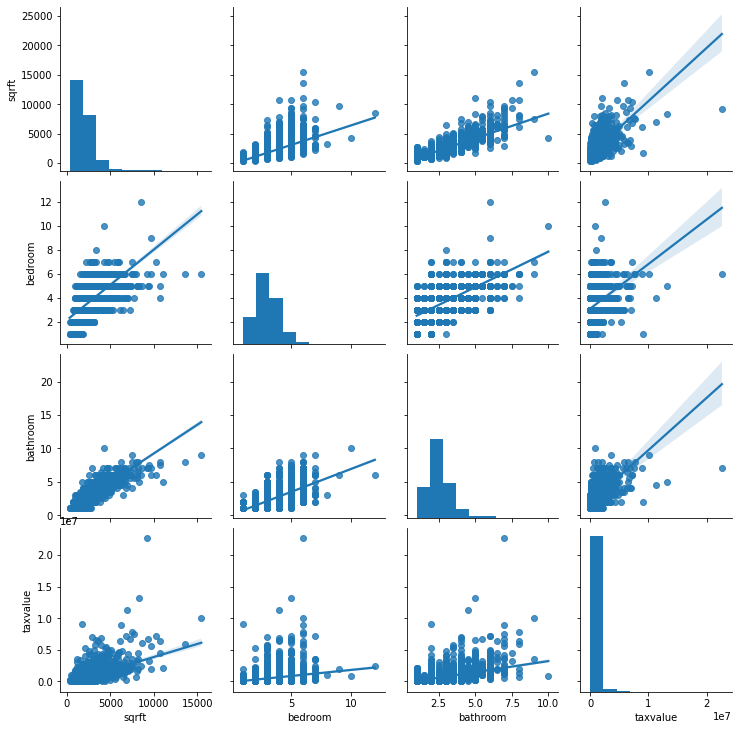

In [19]:
plot_variable_pairs(train)
plt.show()

### Modeling

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

#### Train

In [21]:
X_train = train[['sqrft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_train = train[['taxvalue']]

X_validate = validate[['sqrft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_validate = validate[['taxvalue']]

X_test = test[['sqrft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_test = test[['taxvalue']]

In [22]:
np.mean(y_train)

taxvalue    532383.887592
dtype: float64

In [84]:
baseline_rmse = mean_squared_error(y_train, np.full(8994, np.mean(y_train)))**(1/2)

In [85]:
baseline_rmse

673673.8609438988

In [86]:
from modeling import linearReg_train, lassoLars_train, poly_linearReg_train

In [105]:
lm_rmse = linearReg_train(X_train, y_train)

In [106]:
lm_rmse

522718.3741456403

In [89]:
lars_rmse = lassoLars_train(X_train, y_train)

In [90]:
lars_rmse

522718.42614542664

In [91]:
lm_squared_rmse = poly_linearReg_train(X_train, y_train, 2)

In [92]:
lm_squared_rmse

506873.27042679745

In [112]:
from modeling import select_kbest, rfe

In [95]:
select_kbest(X_train, y_train, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['sqrft_scaled', 'bathroom_scaled']

In [114]:
rfe(X_train, y_train, 2)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['sqrft_scaled', 'bedroom_scaled']

In [115]:
X_train2 = train[['sqrft_scaled', 'bedroom_scaled']]
y_train2 = train[['taxvalue']]

X_validate2 = validate[['sqrft_scaled', 'bedroom_scaled']]
y_validate2 = validate[['taxvalue']]

In [116]:
lm_rmse2 = linearReg_train(X_train2, y_train2)

In [117]:
lm_rmse2

523679.8580758644

In [118]:
lars_rmse2 = lassoLars_train(X_train2, y_train2)

In [119]:
lars_rmse2

523679.90371226973

In [120]:
lm_squared_rmse2 = poly_linearReg_train(X_train2, y_train2, 2)

In [121]:
lm_squared_rmse2

513755.04039224575

In [122]:
print("Baseline, Mean: ", baseline_rmse)
print("Linear Model: ", lm_rmse)
print("LassoLars: ", lars_rmse)
print("Polynomial, squared: ", lm_squared_rmse)

Baseline, Mean:  673673.8609438988
Linear Model:  522718.3741456403
LassoLars:  522718.42614542664
Polynomial, squared:  506873.27042679745


In [123]:
print("Baseline, Mean: ", baseline_rmse)
print("Linear Model: ", lm_rmse2)
print("LassoLars: ", lars_rmse2)
print("Polynomial, squared: ", lm_squared_rmse2)

Baseline, Mean:  673673.8609438988
Linear Model:  523679.8580758644
LassoLars:  523679.90371226973
Polynomial, squared:  513755.04039224575


#### Validate

In [124]:
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

In [125]:
linearReg_validate(X_train, y_train, X_validate, y_validate)

614298.8751654144

In [126]:
lassoLars_validate(X_train, y_train, X_validate, y_validate)

614313.2289232325

In [127]:
poly_linearReg_validate(X_train, y_train, X_validate, y_validate, 2)

575867.9130003428

In [128]:
linearReg_validate(X_train2, y_train2, X_validate2, y_validate2)

616811.9524106013

In [129]:
lassoLars_validate(X_train2, y_train2, X_validate2, y_validate2)

616822.183461359

In [130]:
poly_linearReg_validate(X_train2, y_train2, X_validate2, y_validate2, 2)

595696.651728857

In [74]:
def linearReg_validate(X_train, y_train, X_validate, y_validate):
    lm = LinearRegression(normalize=True)
    lm.fit(X_train, y_train)
    
    lm_pred = lm.predict(X_validate)

    lm_rmse = mean_squared_error(y_validate, lm_pred)**(1/2)
    return lm_rmse

In [76]:
def lassoLars_validate(X_train, y_train, X_validate, y_validate, alpha = 1):
    lars = LassoLars(alpha)
    
    lars.fit(X_train, y_train)
    lars_pred = lars.predict(X_validate)

    lars_rmse = mean_squared_error(y_validate, lars_pred)**(1/2)
    return lars_rmse

In [78]:
def poly_linearReg_validate(X_train, y_train, X_validate, y_validate, degrees):
    pf = PolynomialFeatures(degree=degrees)
    
    X_train_squared = pf.fit_transform(X_train)
    X_validate_squared = pf.transform(X_validate)

    lm_squared = LinearRegression()
    lm_squared.fit(X_train_squared, y_train)

    lm_squared_pred = lm_squared.predict(X_validate_squared)

    lm_squared_rmse = mean_squared_error(y_validate, lm_squared_pred)**(1/2)
    return lm_squared_rmse